# Objetivo
Seleccionar los pozos que tengan mejor comportamiento para hacer las predicciones finales de los diferentes algoritmos elegidos y poder compararlos.

In [1]:
import math
import itertools
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_norm_2024-05-27_03:42:59.csv", index_col=0, low_memory=False)
dataset["fecha"] = pd.to_datetime(dataset["fecha"])
dataset.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140158 entries, 0 to 140157
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   idempresa                140158 non-null  object        
 1   fecha                    140158 non-null  datetime64[ns]
 2   periodo                  140158 non-null  int64         
 3   anio                     140158 non-null  int64         
 4   mes                      140158 non-null  int64         
 5   prod                     140158 non-null  float64       
 6   idpozo                   140158 non-null  int64         
 7   tipopozo                 140158 non-null  object        
 8   prod_pet                 140158 non-null  float64       
 9   prod_gas                 140158 non-null  float64       
 10  prod_agua                140158 non-null  float64       
 11  tef                      140158 non-null  float64       
 12  tipoextraccion  

# Filtrado
Se calcula la producción total por pozo y se descartan los pozos con producción menor a un umbral fijado.

Se grafica histograma, para tener una idea de las frecuencias.


Cantidad total de pozos: 2678
Cantidad de pozos con producción mayor a 0: 2344
Cantidad de pozos con producción mayor a 25000: 868


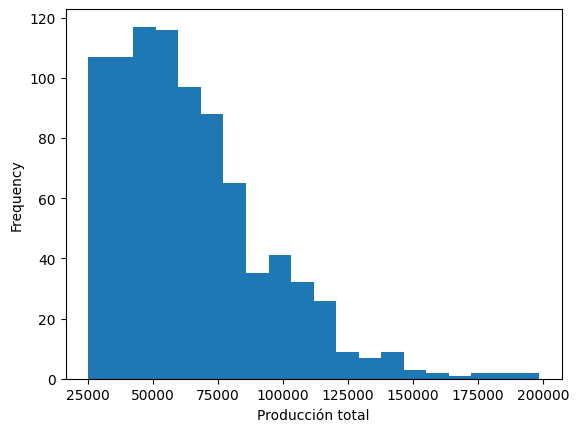

In [4]:
PROD_PET_UMBRAL = 25000

prod_pet_grouped_by_well_id = dataset.groupby(["idpozo"])["prod_pet"].sum().sort_values(ascending=False)
print(f"Cantidad total de pozos: {len(prod_pet_grouped_by_well_id)}")
print(f"Cantidad de pozos con producción mayor a 0: {len(prod_pet_grouped_by_well_id.where(lambda x : x != 0).dropna())}")

#fig1 = prod_pet_grouped_by_well_id.plot.hist(bins=20, xlabel="Producción total")

prod_pet_grouped_by_well_id = prod_pet_grouped_by_well_id.where(lambda x : x > PROD_PET_UMBRAL).dropna()

print(f"Cantidad de pozos con producción mayor a {PROD_PET_UMBRAL}: {len(prod_pet_grouped_by_well_id)}")

fig2 = prod_pet_grouped_by_well_id.plot.hist(bins=20, xlabel="Producción total")

wells_ids_with_prod_greater_to_umbral = prod_pet_grouped_by_well_id.index.to_list()

Se comprueba que los pozos tengan la producción del último año (9 meses de entrenamiento y 3 para predecir)

In [5]:
max_date = dataset["fecha"].max() # fecha maxima de todo el dataset
min_date_needed = max_date.replace(year=(max_date.year - 1)) # fecha minima necesaria para poder predecir el pozo (9 meses min de entrenamiento + 3 para predecir)

last_year_prod_number_grouped_by_well_id = dataset[dataset["fecha"] > min_date_needed].groupby(["idpozo"])["idpozo"].count()

wells_ids_with_last_year_prod = last_year_prod_number_grouped_by_well_id[last_year_prod_number_grouped_by_well_id == 12].index.to_list()

wells_ids = []
for well_id in wells_ids_with_prod_greater_to_umbral:
  if well_id in wells_ids_with_last_year_prod:
    wells_ids.append(well_id)

print(f"Comprobando que los pozos tengan datos de producción entre {min_date_needed.strftime('%d/%m/%Y')} y {max_date.strftime('%d/%m/%Y')}")
print(f"Cantidad de pozos resultantes: {len(wells_ids)}")

Comprobando que los pozos tengan datos de producción entre 01/03/2023 y 01/03/2024
Cantidad de pozos resultantes: 650


# Comparación gráfica
Se grafican las producciones de los pozos de a tandas, para poder compararlos y encontrar las mejores curvas

In [6]:
def plot_prod_pet_of_wells(wells_ids):
  fig, ax = plt.subplots()
  for well_id in wells_ids:
    well_data = dataset[dataset["idpozo"] == well_id]
    if well_data.size > 0:
      well_data = well_data.sort_values(by=["fecha"])

    ax = well_data.plot(ax=ax, x="fecha", y="prod_pet", xlabel="Fecha", ylabel="Producción de petróleo en m3", label=well_id, grid=True)
  plt.show()

In [7]:
NUMBER_OF_WELLS_PER_CHART = 10
NUMBER_OF_WELLS_TO_ANALYZE = len(wells_ids) # todos
#NUMBER_OF_WELLS_TO_ANALYZE = 100
for i in range(math.ceil(NUMBER_OF_WELLS_TO_ANALYZE / NUMBER_OF_WELLS_PER_CHART)):
  plot_prod_pet_of_wells(wells_ids=wells_ids[i*NUMBER_OF_WELLS_PER_CHART : (i+1)*NUMBER_OF_WELLS_PER_CHART])

Output hidden; open in https://colab.research.google.com to view.

In [8]:
def check_well(well_id):
  """
  Chequea que el pozo siga estando entre las condiciones de selección iniciales (puede dejar de estar debido a la limpieza de datos o si algo cambió previamente).
  """
  if well_id in wells_ids:
    print(f"Pozo #{well_id} OK")
  else:
    print(f"Pozo #{well_id} ERROR: el pozo no cumple las condiciones iniciales (posible cambio de datos en el dataset leído)")

In [9]:
#selected_wells_ids = [158364, 160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237, 163942]
selected_wells_ids = [160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237]

for well_id in selected_wells_ids:
  check_well(well_id)

Pozo #160211 OK
Pozo #160332 OK
Pozo #160789 OK
Pozo #160810 OK
Pozo #160814 OK
Pozo #161451 OK
Pozo #162200 OK
Pozo #162405 OK
Pozo #162955 OK
Pozo #163237 OK


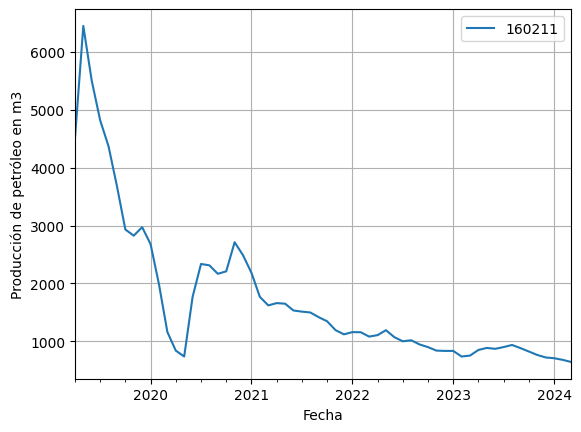

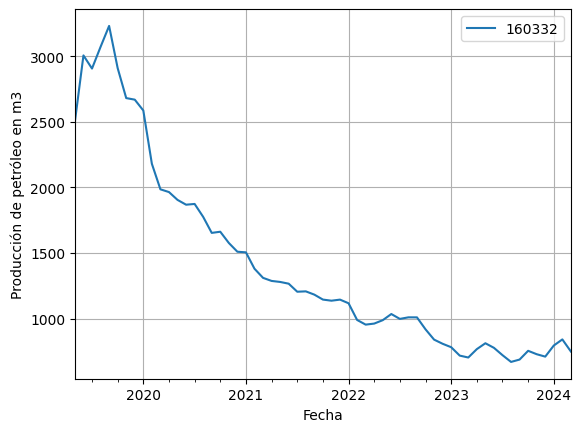

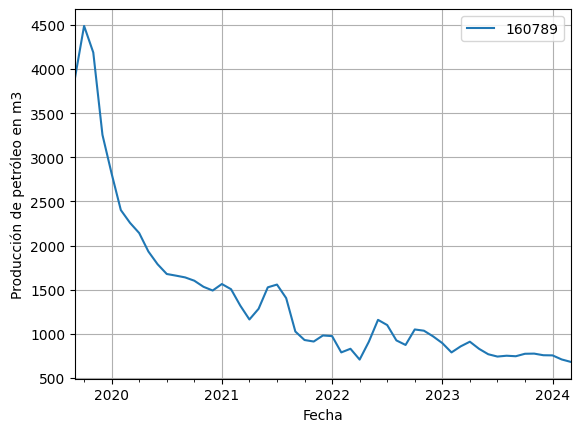

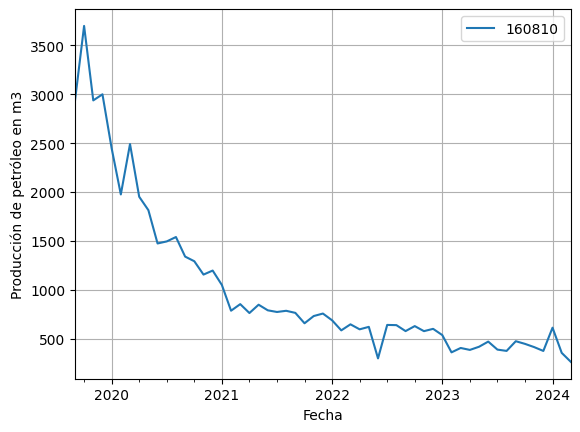

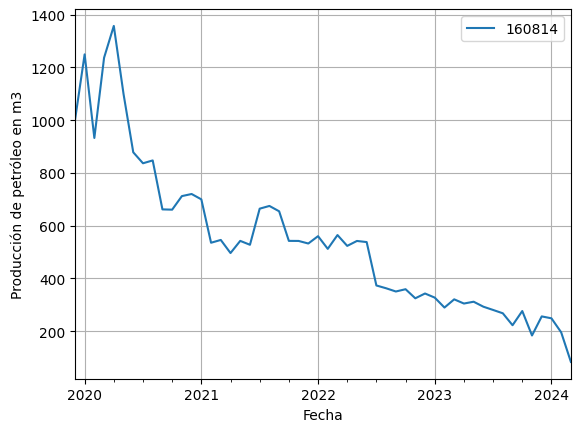

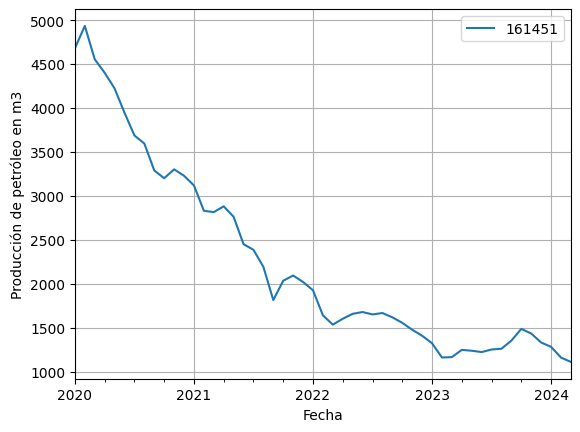

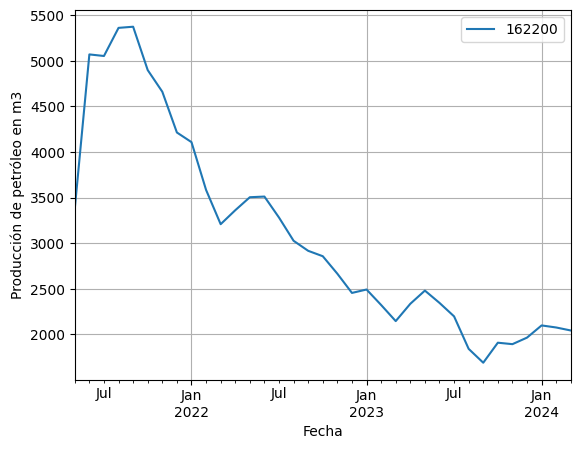

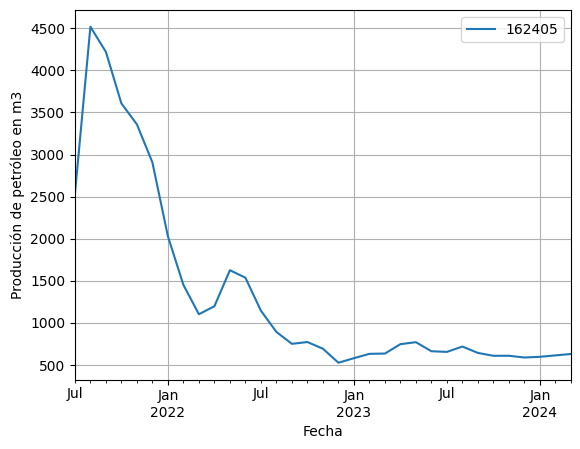

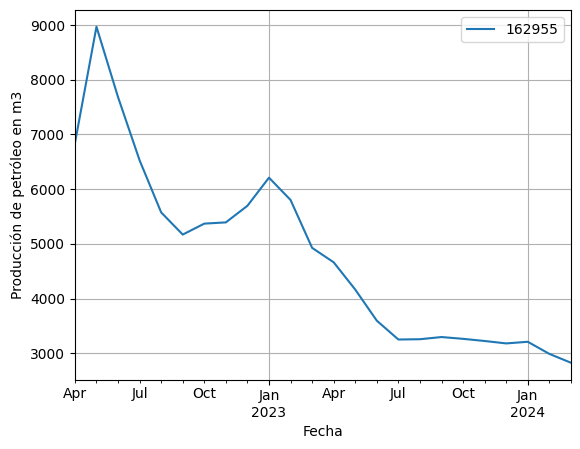

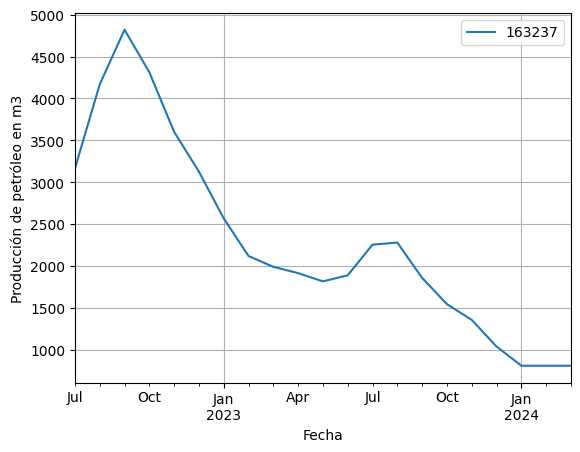

In [10]:
for well_id in selected_wells_ids:
  plot_prod_pet_of_wells([well_id])

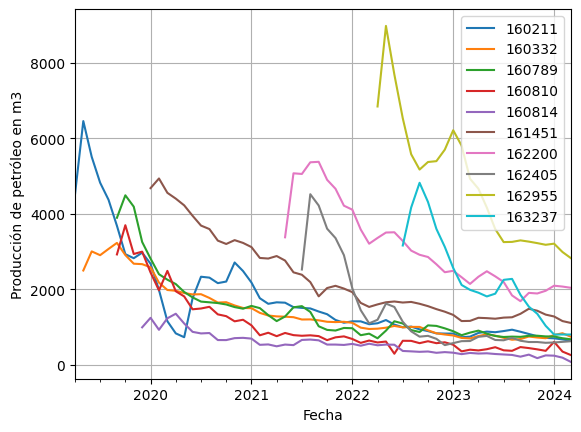

In [11]:
plot_prod_pet_of_wells(wells_ids=selected_wells_ids)

# Resumen de pozos seleccionados

In [12]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [13]:
wells_production = []
production_months = []
areas = []
for well_id in selected_wells_ids:
  wells_production.append(prod_pet_grouped_by_well_id[well_id])
  well_data = dataset[dataset["idpozo"] == well_id]
  production_months.append(diff_month(well_data["fecha"].max(), well_data["fecha"].min()))
  areas.append(well_data.iloc[0]['areayacimiento'])

df_selected_wells = pd.DataFrame(data={'well_id': selected_wells_ids,'wells_pet_production': wells_production, 'production_months': production_months, 'areayacimiento': areas})
df_selected_wells

,well_id,wells_pet_production,production_months,areayacimiento
0,160211,104208.220666,59,MEDANO DE LA MORA
1,160332,83413.490000,58,SIERRA BARROSA
2,160789,77033.565950,54,LINDERO ATRAVESADO OCCIDENTAL
3,160810,55746.346000,54,LA CALERA
4,160814,28361.903000,51,LA CALERA
5,161451,115000.276000,50,COIRON AMARGO SUR ESTE
6,162200,108338.545000,34,BANDURRIA SUR
7,162405,44562.100000,32,LA AMARGA CHICA
8,162955,115085.770244,23,BAJADA DEL PALO ESTE
9,163237,48232.165000,20,LOMA CAMPANA


In [14]:
import folium
import matplotlib
import seaborn as sns

# Wells unique ids with columns "latitude", "longitude", and "area"
wells_geo = pd.DataFrame()
wells_geo[["idpozo", "longitude", "latitude", "areayacimiento"]] = dataset.drop_duplicates(subset='idpozo')[["idpozo", "coordenadax", "coordenaday", "areayacimiento"]]
wells_geo = wells_geo[wells_geo["idpozo"].isin(wells_ids)]

# Create a folium map centered at an initial location
map_center = [wells_geo['latitude'].mean(), wells_geo['longitude'].mean()]
wells_geo_map = folium.Map(location=map_center, zoom_start=10)

# Get unique areas from the "area" column
areas = wells_geo[["areayacimiento"]].value_counts()
areas = areas[areas >= 10].index.get_level_values(0).to_list() # There are many areas with less than 10 wells. We dont want to have a lot of different markers


# markers_colors = ['red', 'blue', 'orange', 'green', 'purple', 'pink', 'cadetblue', 'darkred',
#                   'lightred', 'darkpurple', 'darkgreen', 'lightgreen', 'darkblue', 'lightblue']

markers_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5'] #sns.color_palette(palette='tab20').as_hex() without greys
markers_shapes = ["circle", "triangle", "rectangle"]

markers = []

# Add markers for each well with custom colors
for index, row in wells_geo.iterrows():
  area = row['areayacimiento']
  area_color = '#ff0033' if row['idpozo'] in selected_wells_ids else '#828282'
  tooltip = f"#{row['idpozo']} ({area})"
  fill_opacity = 0.6
  lat = row['latitude']
  lon = row['longitude']

  marker = folium.Circle(
      location=[lat, lon], radius=300, # meters
      color=area_color, fill=True, fill_color=area_color, fill_opacity=fill_opacity, tooltip=tooltip)

  if row['idpozo'] in selected_wells_ids:
    markers.append(marker)
  else:
    marker.add_to(wells_geo_map)

for marker in markers:
  marker.add_to(wells_geo_map)


# Save the map to an HTML file
#wells_geo_map.save("/content/drive/MyDrive/Trabajo profesional/Code/data/wells_geo_map_selection_welss.html")

# Display
wells_geo_map